<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
Final Project - Machine Learning Short Term Stock Price <br><br> Movements with A2M.AX</p><br>
<br>
The aim of this project is to answer the following question:

**With the help of daily stock data and machine learning tools, are we able to predict short term future price movements of stock?**

The reason for this investigation is that I've always been curious about whether future stock prices can be predicted with any accuracy whatsoever using historical time series data and basic machine learning methods. 

The dataset used is from Yahoo Finance. It contains 1,180 data samples of daily stock data for the stock A2M.AX, listed on the ASX. The data range is from 31 March 2015 to 22 November 2019. 

You can obtain similar data yourself by creating a proile on Yahoo Finance, and adding whatever stock or stocks you're interested to your portfolio, then exporting the data using csv format.

Location: https://finance.yahoo.com/

In [73]:
%config IPCompleter.greedy=True

# Below can be used to change the width of the Jupyter notebook.

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

Let's load our data in to the notebook and check out a few key features of it to get an idea how it's shaped and how it looks.

In [75]:
data = pd.read_csv('A2M-ASX.csv')

In [76]:
print(data.shape)
[x for x in data.columns]

(1180, 26)


['date',
 'open',
 'high',
 'low',
 'close',
 'adj_close',
 'range_over_open',
 'range_change',
 'range_move',
 'price_change',
 'tomo_price_move',
 'volume',
 'qty_change',
 'qty_move',
 '5d_avg_range',
 'change_in_5d_avg_range',
 '5d_avg_range_move',
 '5d_avg_px',
 'change_in_5d_avg_px',
 '5d_avg_px_move',
 '5d_avg_qty',
 'change_in_5d_avg_qty',
 '5d_avg_qty_move',
 '10d_avg_px',
 'change_in_10d_avg_px',
 '10d_avg_px_move']

Off the bat we can see how many features each data sample has, and what these features are. As can be seen, it's a mixture of price and volume data for daily intervals.

Let's view some of the data.

In [77]:
data[:10]

,date,open,high,low,close,adj_close,range_over_open,range_change,range_move,price_change,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
0,3/31/2015,0.555,0.595,0.530,0.565,0.565,0.117117,NaN,Flat,0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/1/2015,0.575,0.580,0.555,0.565,0.565,0.043478,-0.073639,Down,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/2/2015,0.560,0.565,0.535,0.555,0.555,0.053571,0.010093,Up,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/7/2015,0.545,0.550,0.540,0.545,0.545,0.018349,-0.035223,Down,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4/8/2015,0.545,0.545,0.530,0.540,0.540,0.027523,0.009174,Up,-0.005,...,NaN,0.554,NaN,NaN,2606643.8,NaN,NaN,NaN,NaN,NaN
5,4/9/2015,0.540,0.540,0.532,0.535,0.535,0.014815,-0.012708,Down,-0.005,...,Down,0.548,-0.006,Down,1784754.2,-821889.6,Down,NaN,NaN,NaN
6,4/10/2015,0.530,0.535,0.530,0.535,0.535,0.009434,-0.005381,Down,0.000,...,Down,0.542,-0.006,Down,944443.0,-840311.2,Down,NaN,NaN,NaN
7,4/13/2015,0.535,0.540,0.530,0.540,0.540,0.018692,0.009258,Up,0.005,...,Down,0.539,-0.003,Down,501676.6,-442766.4,Down,NaN,NaN,NaN
8,4/14/2015,0.540,0.540,0.535,0.540,0.540,0.009259,-0.009432,Down,0.000,...,Down,0.538,-0.001,Down,497519.4,-4157.2,Down,NaN,NaN,NaN
9,4/15/2015,0.540,0.550,0.540,0.540,0.540,0.018519,0.009259,Up,0.000,...,Down,0.538,0.000,Flat,548980.0,51460.6,Up,0.546,NaN,NaN


Immediately we can see there are a number of NaN values. These will need dealing with. 

Let's view them all first to see why they are there and if we should simply removing or altering to another value.

In [78]:
nulls = data.isnull().any(axis=1)
data[nulls]

,date,open,high,low,close,adj_close,range_over_open,range_change,range_move,price_change,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
0,3/31/2015,0.555,0.595,0.530,0.565,0.565,0.117117,NaN,Flat,0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/1/2015,0.575,0.580,0.555,0.565,0.565,0.043478,-0.073639,Down,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/2/2015,0.560,0.565,0.535,0.555,0.555,0.053571,0.010093,Up,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/7/2015,0.545,0.550,0.540,0.545,0.545,0.018349,-0.035223,Down,-0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4/8/2015,0.545,0.545,0.530,0.540,0.540,0.027523,0.009174,Up,-0.005,...,NaN,0.554,NaN,NaN,2606643.8,NaN,NaN,NaN,NaN,NaN
5,4/9/2015,0.540,0.540,0.532,0.535,0.535,0.014815,-0.012708,Down,-0.005,...,Down,0.548,-0.006,Down,1784754.2,-821889.6,Down,NaN,NaN,NaN
6,4/10/2015,0.530,0.535,0.530,0.535,0.535,0.009434,-0.005381,Down,0.000,...,Down,0.542,-0.006,Down,944443.0,-840311.2,Down,NaN,NaN,NaN
7,4/13/2015,0.535,0.540,0.530,0.540,0.540,0.018692,0.009258,Up,0.005,...,Down,0.539,-0.003,Down,501676.6,-442766.4,Down,NaN,NaN,NaN
8,4/14/2015,0.540,0.540,0.535,0.540,0.540,0.009259,-0.009432,Down,0.000,...,Down,0.538,-0.001,Down,497519.4,-4157.2,Down,NaN,NaN,NaN
9,4/15/2015,0.540,0.550,0.540,0.540,0.540,0.018519,0.009259,Up,0.000,...,Down,0.538,0.000,Flat,548980.0,51460.6,Up,0.546,NaN,NaN


We see that the null data is mostly our data which contains averages for preceding days, as these data points don't have enough previous days to average. The last row is also NaN as it is missing a value for 'tomo_price_move' as the next day's price wasn't known the time this data was created.

Let's remove these data points as they shouldn't affect our end results too much, and there's no other way to know what these data points should be without digging for more data.

In [79]:
data = data.dropna()
print(data.shape)
data.head()

(1169, 26)


,date,open,high,low,close,adj_close,range_over_open,range_change,range_move,price_change,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
10,4/16/2015,0.545,0.545,0.525,0.53,0.53,0.036697,0.018179,Up,-0.01,...,Up,0.537,-0.001,Down,526133.4,-22846.6,Down,0.5425,-0.0035,Down
11,4/17/2015,0.525,0.540,0.520,0.54,0.54,0.038095,0.001398,Up,0.01,...,Up,0.538,0.001,Up,600670.6,74537.2,Up,0.5400,-0.0025,Down
12,4/20/2015,0.535,0.535,0.520,0.52,0.52,0.028037,-0.010058,Down,-0.02,...,Up,0.534,-0.004,Down,562333.0,-38337.6,Down,0.5365,-0.0035,Down
13,4/21/2015,0.525,0.530,0.520,0.52,0.52,0.019048,-0.008990,Down,0.00,...,Up,0.530,-0.004,Down,618294.0,55961.0,Up,0.5340,-0.0025,Down
14,4/22/2015,0.520,0.530,0.520,0.52,0.52,0.019231,0.000183,Up,0.00,...,Up,0.526,-0.004,Down,511622.2,-106671.8,Down,0.5320,-0.0020,Down


Let's check if our date data is Pandas datetime format so we can actually predict using it.

In [80]:
data.dtypes

date                       object
open                      float64
high                      float64
low                       float64
close                     float64
adj_close                 float64
range_over_open           float64
range_change              float64
range_move                 object
price_change              float64
tomo_price_move            object
volume                      int64
qty_change                float64
qty_move                   object
5d_avg_range              float64
change_in_5d_avg_range    float64
5d_avg_range_move          object
5d_avg_px                 float64
change_in_5d_avg_px       float64
5d_avg_px_move             object
5d_avg_qty                float64
change_in_5d_avg_qty      float64
5d_avg_qty_move            object
10d_avg_px                float64
change_in_10d_avg_px      float64
10d_avg_px_move            object
dtype: object

We confirm the `date` column is the generic object type which could be a string. Since we want to perform time related actions on this data, we need to convert it to a datetime format before it can be useful to us. Let’s go ahead and do this using the `.to_datetime()` method.

By checking dtype again we confirm the date is now datetime format.

In [81]:
data['date'] = pd.to_datetime(data['date'])
data.dtypes

date                      datetime64[ns]
open                             float64
high                             float64
low                              float64
close                            float64
adj_close                        float64
range_over_open                  float64
range_change                     float64
range_move                        object
price_change                     float64
tomo_price_move                   object
volume                             int64
qty_change                       float64
qty_move                          object
5d_avg_range                     float64
change_in_5d_avg_range           float64
5d_avg_range_move                 object
5d_avg_px                        float64
change_in_5d_avg_px              float64
5d_avg_px_move                    object
5d_avg_qty                       float64
change_in_5d_avg_qty             float64
5d_avg_qty_move                   object
10d_avg_px                       float64
change_in_10d_av

Let's also index by date to explore the data. We do this using the `.set_index()` method.

In [82]:
data = data.set_index('date')

In [83]:
data.head()

,open,high,low,close,adj_close,range_over_open,range_change,range_move,price_change,tomo_price_move,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
date,,,,,,,,,,,,,,,,,,,,,
2015-04-16,0.545,0.545,0.525,0.53,0.53,0.036697,0.018179,Up,-0.01,Up,...,Up,0.537,-0.001,Down,526133.4,-22846.6,Down,0.5425,-0.0035,Down
2015-04-17,0.525,0.540,0.520,0.54,0.54,0.038095,0.001398,Up,0.01,Down,...,Up,0.538,0.001,Up,600670.6,74537.2,Up,0.5400,-0.0025,Down
2015-04-20,0.535,0.535,0.520,0.52,0.52,0.028037,-0.010058,Down,-0.02,Flat,...,Up,0.534,-0.004,Down,562333.0,-38337.6,Down,0.5365,-0.0035,Down
2015-04-21,0.525,0.530,0.520,0.52,0.52,0.019048,-0.008990,Down,0.00,Flat,...,Up,0.530,-0.004,Down,618294.0,55961.0,Up,0.5340,-0.0025,Down
2015-04-22,0.520,0.530,0.520,0.52,0.52,0.019231,0.000183,Up,0.00,Down,...,Up,0.526,-0.004,Down,511622.2,-106671.8,Down,0.5320,-0.0020,Down


When plotting, as can be seen, given that we are doing time series, time is on the x axis and the y axis contains the magnitude of the data. By plotting the price data we can see change in price over time. 

Notice how the date column was used as our x-axis and because we had previously casted our date column to datetime, the graph was plotted in half yearly intervals. (It knows how to adjust given the date datatype).

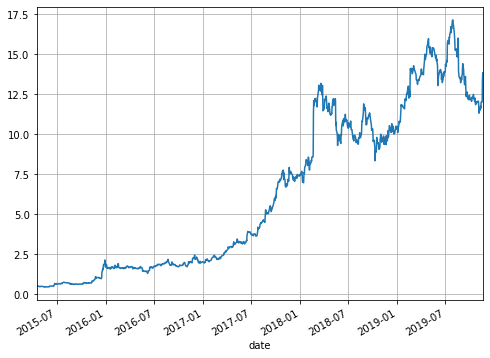

In [84]:
data['adj_close'].plot(grid=True, figsize=(8, 6))

Now that our data is clean, lets's find some more interesting aspects of our data. 

Using Panda's `.describe()` method we can analyse basic statistical properties of the data set. Note this only works for numerical data.

Given the length of the data, and the change of A2M.AX over time, this is not very useful for basic price data, but is more interesting for range and volume data, as well as averaged price data.

In [85]:
data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
open,1169.0,6.32,5.06,0.47,1.74,4.22,10.94,17.20
high,1169.0,6.41,5.13,0.48,1.76,4.28,11.14,17.30
low,1169.0,6.22,4.99,0.46,1.72,4.15,10.80,17.03
close,1169.0,6.31,5.06,0.46,1.74,4.23,10.97,17.13
adj_close,1169.0,6.31,5.06,0.46,1.74,4.23,10.97,17.13
range_over_open,1169.0,0.03,0.02,0.00,0.02,0.03,0.04,0.27
range_change,1169.0,0.00,0.03,-0.22,-0.01,-0.00,0.01,0.14
price_change,1169.0,0.01,0.22,-2.11,-0.05,0.00,0.06,2.59
volume,1169.0,4850434.12,5403130.18,0.00,2226168.00,3501875.00,5363882.00,61397295.00
qty_change,1169.0,4556.46,4973510.84,-41366403.00,-1186807.00,-113648.00,1031337.00,41677409.00


I feel like range change may be a useful indicator but lets continue investigating. 

Note: `range_over_price = (high-low)/open`

## Simple Classification


Let's start with a simple classification. For each data sample, we will try to classify tomorrow's price movement (be it up, down or flat).

We must first define our features, and then the target. For features let's use everything except 'tomo_price_move' which will be our target.

In [93]:
features = ['open', 'high', 'low', 'close', 'adj_close', 'range_over_open', 'range_change', 'range_move', 'price_change', 'volume', \
            'qty_change', 'qty_move', '5d_avg_range', 'change_in_5d_avg_range', '5d_avg_range_move', '5d_avg_px', 'change_in_5d_avg_px', \
            '5d_avg_px_move', '5d_avg_qty', 'change_in_5d_avg_qty', '5d_avg_qty_move', '10d_avg_px', 'change_in_10d_avg_px', '10d_avg_px_move']

target = ['tomo_price_move']

Our labels in our `tomo_price_move` target are "Up", "Down" and "Flat". These will need changing to numbers in order for our model to correctly train. Data in our features containing these same labels will also need changing to numbers.

Let's remove the data where tomorrow's price move is flat as these are less frequent. Doing this means we can make our classification a binary task.

    Up - 1
    Down - 0

In [94]:
no_flats = data['tomo_price_move'] != 'Flat'
new_data = data[no_flats]
print(new_data.shape)
new_data.head()

(1100, 25)


,open,high,low,close,adj_close,range_over_open,range_change,range_move,price_change,tomo_price_move,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
date,,,,,,,,,,,,,,,,,,,,,
2015-04-16,0.545,0.545,0.525,0.530,0.530,0.036697,0.018179,Up,-0.01,Up,...,Up,0.537,-0.001,Down,526133.4,-22846.6,Down,0.5425,-0.0035,Down
2015-04-17,0.525,0.540,0.520,0.540,0.540,0.038095,0.001398,Up,0.01,Down,...,Up,0.538,0.001,Up,600670.6,74537.2,Up,0.5400,-0.0025,Down
2015-04-22,0.520,0.530,0.520,0.520,0.520,0.019231,0.000183,Up,0.00,Down,...,Up,0.526,-0.004,Down,511622.2,-106671.8,Down,0.5320,-0.0020,Down
2015-04-23,0.520,0.520,0.510,0.510,0.510,0.019231,0.000000,Flat,-0.01,Down,...,Down,0.522,-0.004,Down,678138.4,166516.2,Up,0.5295,-0.0025,Down
2015-04-27,0.505,0.510,0.500,0.505,0.505,0.019802,-0.019414,Down,0.00,Down,...,Down,0.512,-0.003,Down,751161.0,-30650.4,Down,0.5230,-0.0035,Down


Removing flat days got rid of 69 further data point. We have 1,100 samples remaining.

Remember we are using the daily stock data (f(x)) to come up with a predictor for tomorrow's stock price movement (y).

In [95]:
x = new_data[features].copy()
y = new_data[target].copy()

In [96]:
x.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'range_over_open',
       'range_change', 'range_move', 'price_change', 'volume', 'qty_change',
       'qty_move', '5d_avg_range', 'change_in_5d_avg_range',
       '5d_avg_range_move', '5d_avg_px', 'change_in_5d_avg_px',
       '5d_avg_px_move', '5d_avg_qty', 'change_in_5d_avg_qty',
       '5d_avg_qty_move', '10d_avg_px', 'change_in_10d_avg_px',
       '10d_avg_px_move'],
      dtype='object')

In [97]:
y.columns

Index(['tomo_price_move'], dtype='object')

In [98]:
y.replace({"Up" : 1, "Down" : 0}, inplace=True)
x.replace({"Up": 1, "Down" : -1, "Flat" : 0}, inplace=True)

y.head()

,tomo_price_move
date,
2015-04-16,1
2015-04-17,0
2015-04-22,0
2015-04-23,0
2015-04-27,0


## Let's perform our Training and Test data split

### REMINDER: Training Phase

In the `training phase`, the learning algorithm uses the training data to adjust the model’s parameters to minimize errors.  At the end of the training phase, you get the trained model.

In the `testing phase`, the trained model is applied to test data.  Test data is separate from the training data, and is previously unseen by the model.  The model is then evaluated on how it performs on the test data.  The goal in building a classifier model is to have the model perform well on training as well as test data.

From sklearn.model_selection let's use the `train_test_split()` function to split our datasets in to training and test subsets. It takes in arguments of 2 dataframes (x, y), and returns 4 dataframes (x_train, x_test, y_train, y_test).

Note: `train_test_split()` splits the data **randomly** into train and test subsets. It must be considered whether this is appropriate for the given dataset or if non random methods are preferred.

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=369)

## Now that our data's split, let's fit the training data

Below we are trying to fit the model on to the training dataset. Let's start with a `Decision Tree Classifier`. From sklearn.tree we import and use DecisionTreeClassifier().

In [100]:
px_movement_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

We then fit our classifier using it's `.train(x_train, y_train)` method.

In [101]:
px_movement_classifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

By checking our most important features of our classifier, we can see that only 8 features of our original 24 features have been assigned weight, with `5d_avg_px` being the highest wait at 0.242. 

The rest are 0! We may need to rethink about the features of our model..

Regardless, let's see how the model performs on our test set.

In [104]:
px_movement_classifier.feature_importances_

array([0.        , 0.        , 0.10641858, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.12262594, 0.        ,
       0.11996703, 0.        , 0.12031844, 0.        , 0.        ,
       0.24240973, 0.        , 0.        , 0.09349205, 0.07899515,
       0.        , 0.11577308, 0.        , 0.        ])

In [105]:
x_features = pd.DataFrame(px_movement_classifier.feature_importances_)
x_features['feature'] = pd.Series(x.columns)
x_features.columns = ['weight', 'feature']
pos_weights = x_features['weight'] > 0
x_features[pos_weights]

,weight,feature
2,0.106419,low
8,0.122626,price_change
10,0.119967,qty_change
12,0.120318,5d_avg_range
15,0.242410,5d_avg_px
18,0.093492,5d_avg_qty
19,0.078995,change_in_5d_avg_qty
21,0.115773,10d_avg_px


## Predicting on our test set

We use the `.predict()` method of the DecisionTreeClassifier object to predict y values on our unseen x_test data. We are asking our decision tree classifier model to predict on the test set which it has not see at all during its training. 

The returned value is a vector of our model's predictions of stock price movement for the following day. (0 for down, 1 for up). We store this in variable 'predictions'.

In [107]:
predictions = px_movement_classifier.predict(x_test)
type(predictions)

numpy.ndarray

Below we see the first 10 predicitons of our model on the x test data for y, and then compare it to the actual test data labels for y. Remember our predictions are the predicted stock price movement for the following day on what the model learned from the training set.

We can see that our predicions are surprisingly **accurate**, with 8 out of 10 being correct. An error has occured for 2 out of the 10 labels. This is when the model's prediction of the class label is different to the true class label. I would say this is luck more then anything, but lets dig further..

In [110]:
predictions[:10]

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 1], dtype=int64)

In [111]:
y_test['tomo_price_move'][:10]

date
2017-04-04    1
2018-03-01    0
2016-12-29    1
2016-01-08    0
2019-04-16    0
2018-10-11    1
2016-06-23    0
2019-05-29    0
2018-04-11    0
2019-01-04    1
Name: tomo_price_move, dtype: int64

## Measuring the accuracy of our decision tree classifier 

From sklearn.metrics we can import and use the `accuracy_score(y_true, y_pred)` function. This allows us to test the accuracy of our classifier. The arguments are as below:

y_true : 1d array-like, Ground truth (correct) labels.

y_pred : 1d array-like, Predicted labels, as returned by a classifier.

In [112]:
accuracy_score(y_true=y_test, y_pred=predictions).round(4)

0.5182

Our accuracy for this classifier is only 51.8%, which is more or less the same as guessing. Perhaps there is some sort of edge?

Let's plot the data to see how our guesses tracked over time. First let's convert our predictions ndarray in to a Pandas dataframe, and merge it with the `y_test` `tomo_price_move` values using the `.join()` method.

As `predictions_df` currently has a numeric index, let's specify the joined dataframe to have y_test's index of dates, using the `.set_index()` method.

In [113]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns=['prediction']
predictions_compare = y_test.join(predictions_df.set_index(y_test.index))
predictions_compare.head()

,tomo_price_move,prediction
date,,
2017-04-04,1,1
2018-03-01,0,0
2016-12-29,1,1
2016-01-08,0,0
2019-04-16,0,0


To see where our predictions were accurate (whether by chance or not), let's insert a new boolean column that equals True for correct predictions and False for incorrect predictions.

In [114]:
correct_predictions = predictions_compare['tomo_price_move'] ==  predictions_compare['prediction'] 
# convert Boolean values to binary
correct_predictions = correct_predictions * 1

predictions_compare['correct_predictions'] = correct_predictions
predictions_compare.head()

,tomo_price_move,prediction,correct_predictions
date,,,
2017-04-04,1,1,1
2018-03-01,0,0,1
2016-12-29,1,1,1
2016-01-08,0,0,1
2019-04-16,0,0,1


Let's plot correct_predictions over the timeline to see if there were any consistencies in guesses at different points in time, or if the predictions appear random. 

To do this, we'll use `plt.broken_barh(xranges, yranges)`. `broken_barh()` plots a horizontal sequence of rectangles. A rectangle is drawn for each element of *xranges*. All rectangles have the same vertical position and size defined by *yranges*.

In [115]:
# matplotlib.dates allows us to be specific with our x axis ticks etc.
import matplotlib.dates

def predictions_barplot(year=None):

# create a time series s with dates as index and 0 and 1 for events
# Note: we can index here by year, e.g. ['2018'] if we want to return the predictions plotted for a given year.
    s = predictions_compare['correct_predictions'][year:year]

# when using fig, ax = plt.subplots(): fig (Figure) represents the top level container for all the plot elements.
# ax represents an axes in the figure. Note: Multiple axes can be displayed in the same figure. 
# The Axes contains most of the figure elements: Axis, Tick, Line2D, Text, Polygon, etc., and sets the coordinate system.

# The plt.subplots(nrows=1, ncols=1) method creates a figure and a set of subplots. An array of axes can be returned rather than a single axes by increae ncols or nrows.
# nrows and ncols determine how the multiple axes are laid out. E.g. nrows=2, ncols=1 would return 2 axes that are displayed with one on top of the other.
# Note: The multiple axes fit within the same Figure. If using many axes, you may want to increase figsize to account for this.
# if returning multiple axes, the axes varibles must be passed in as a tuple, e.g. fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharedy=True)
    fig, ax= plt.subplots(figsize=(15,5))


# plot green for event == 1

# To plot for correct_predictions == 1, we first index our predictions for values that are == 1
    s1 = s[s == 1]

# Then, using matplotlib's .dates.date2num() method, we pass in our index values, converted to pydatetime, for where correct_predictions are 1.
# This returns numeric values for our dates. (Note: not sure if we need to do this - may be able to leave our date values as is and simply set inxval = s1.index),
#inxval = s1.index
    inxval = matplotlib.dates.date2num(s1.index.to_pydatetime())

# As .broken_barh(xranges, yrange) requires a tuple of (*xmin*, *xwidth*) for xranges, we must make our dates for correct predictions tuples. An easy way to do this
# is to use Python's zip() function which returns a zip object whose .__next__() method returns a tuple where the i-th element comes from the i-th iterable argument.
    times= zip(inxval, np.ones(len(s1)))

# As broken_barh() can't accept a zip object as an argument, let's change the zip object to a list then pass it in.
# Remember yranges argument is the y-position and extends for all the rectangles. Argument is a tuple, (*ymin*, *ymax*), 
# ymin being the starting point, ymax being how far y extends.
    times = list(times)
    plt.broken_barh(times, (-1,1), color="green")


# plot red for event==0

# Plotting for correct_predictions == 0 is more or less the same as plotting for == 1. We make the color red for incorrect predictions.
    s2 = s[s == 0]
    inxval = matplotlib.dates.date2num(s2.index.to_pydatetime())
    times= zip(inxval, np.ones(len(s2)))
    times = list(times)
    plt.broken_barh(times, (-1,1), color="red")

# Here we format the axes. The methods are passed on our axes object 'ax'.

# .margins() sets the margins of the axes. Setting to 0 eliminates margins, and pushes our values to the edge.
    ax.margins(0)

# .set_yticks() allows us to set the tick values on the y axis. Setting to an empty list removes them from our axes.
    ax.set_yticks([])

# .set_major_locator() sets the locator of the major ticker. We are doing this specifically for the x axis.
# by passing in dates.YearLocator(base=1, month=1, day=1), we are able to specify the major ticker to make ticks on a given day of each year that is a multiple of base
# (base=1 implies to make ticks every year, base=2 implies to make ticks every 2 years, etc.)
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())

# .set_minor_locator() works similarly to .set_major_locator() except it sets the locator of the minor ticker.
# .dates.MonthLocator(bymonth=None, bymonthday=1, interval=1,) allows us to specify the minor ticket to make ticks on occurrences of each month, e.g., 1, 3, 12.
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

# dates.DateFormatter() allows us to format dates using a strftime() method to return a string representing date and time using date, time or datetime objects. It takes in format
# specification arguments. See http://strftime.org/ for more info on these arguments.
    yearFmt = matplotlib.dates.DateFormatter("%Y")
    monthFmt = matplotlib.dates.DateFormatter("%b")

# We then set these formatter objects to the major and minor tickers using the .set_major_formatter() and .set_minor_formatter() methods on the xaxis.
    ax.xaxis.set_major_formatter(yearFmt)
    ax.xaxis.set_minor_formatter(monthFmt)

# using kwargs for .xticks(), we can specify properties that can be used to control the appearance of the labels. xticks here only allows us to modify the major ticks.
    plt.xticks(rotation=90, fontsize=11)

# To change the property of the minor ticks, we use the plt.setp(obj, *args, **kwargs) method to set properties on an artist object.
# Remember, artist objects handle all of the high level constructs like representing and laying out the figure, text, and lines.
# Similar to the major ticks above, we are only setting the rotation and fontsize kwargs.
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=10)

# The .tight_layout(pad=1.08) method automatically adjusts subplot parameters to give specified padding.
# The pad argument represents Padding between the figure edge and the edges of subplots, as a fraction of the font size.
    plt.tight_layout()
    plt.show()

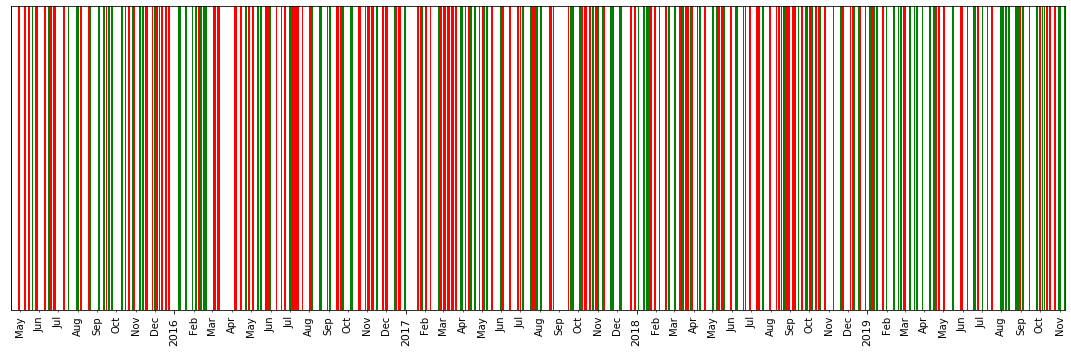

In [116]:
predictions_barplot()

The reason for the whitespaces in our plot is because this is only our test data being displayed. The whitespaces represent data from our training set. 

Interestingly there do appear to be periods where the predictions were fairly accurate (Mar-Apr 2019), and fairly innaccurate (Dec 2015).
 
While the presence of whitespace makes it difficult to draw any definite conclusions with regards to seasonality of our model's accuracy, it still appears random.

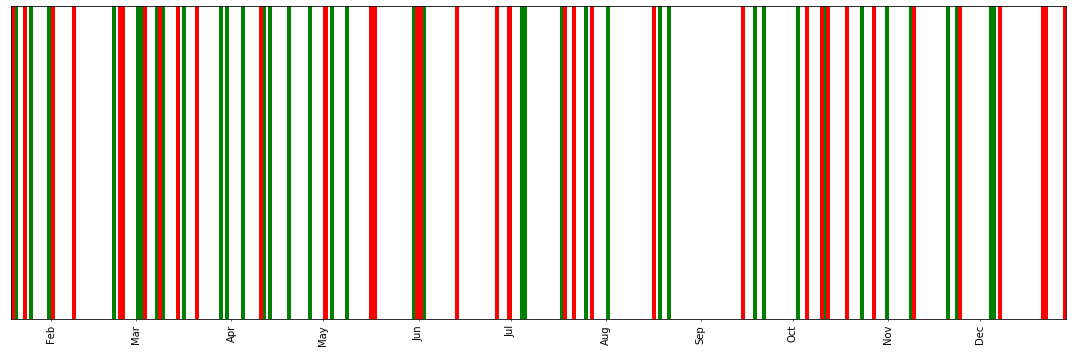

In [117]:
predictions_barplot('2017')

When we index by year, we can see just how many datapoints are missing. Seeing this confirms there must be a better way to go about modelling and testing on our data. 

In the above plot, due to the random nature of the train test split we performed on our data, almost no data was tested on for September 2017.

Quite frankly this is never going to produce a model of any value. As our data is `timeseries`, we need to think differently.

## The goal of time series forecasting is to make accurate predictions about the future.

The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal (time-related) components inherent in the problem.

`Train-test splits`, `multiple train-test splits` and `walk-forward validation models` of time series data for model evaluation provide the most realistic evaluation of machine learning models on time series data.

Note: When doing train test splits, the split should **not be random** for time series modelling. This is because we do not want to take in to account future information for predicting historical values.

See more: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

## Multiple train test split model

<br>
Let's try a `multiple train test split mpdel` for model evaluation to see if this yields better results. At the least it should return predictions for each date beyond a chosen period .

The multiple train test split model repeats the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.

Conveniently, the scikit-learn library provides this capability for us in the `TimeSeriesSplit` object. You must specify the number of splits to create and the TimeSeriesSplit object returns the indices of the train and test observations for each requested split.

The total number of training and test observations are calculated for each **split iteration (i)** as follows:

    training_size = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)<br>
    test_size = n_samples / (n_splits + 1)

Where n_samples is the total number of observations and n_splits is the total number of splits.

Let’s make this concrete with an example. Assume we have 100 observations and we want to create 2 splits.

For the first split, the train and test sizes would be calculated as:

    train = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
    train = 1 * 100 / (2 + 1) + 100 % (2 + 1)
    train = 33.3 or 33

    test = n_samples / (n_splits + 1)
    test = 100 / (2 + 1)
    test = 33.3 or 33

Or the first 33 records are used for training and the next 33 records are used for testing.

The second split is calculated as follows:

    train = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
    train = 2 * 100 / (2 + 1) + 100 % (2 + 1)
    train = 66.6 or 67

    test = n_samples / (n_splits + 1)
    test = 100 / (2 + 1)
    test = 33.3 or 33

Or, the first 67 records are used for training and the remaining 33 records are used for testing.

You can see that the `test size stays consistent`. This means that performance statistics calculated on the predictions of each trained model will be consistent and can be combined and compared. It provides an apples-to-apples comparison.

What differs is the number of records used to train the model each split, offering a larger and larger history to work with. This may make an interesting aspect of the analysis of results. Alternately, this too could be controlled by holding the number of observations used to train the model consistent and only using the same number of the most recent (last) observations in the training dataset each split to train the model (33 in this contrived example).

More info: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

Let's split our data in to 7 different periods. As we have 54 months of data, this is in approx. 8 month increments, meaning our predicted target values will begin shortly before the beginning of 2016, and extend all the way out to the end of our dataset.

In [258]:
from sklearn.model_selection import TimeSeriesSplit

# Creating our TimeSeriesSplitObject
splits = TimeSeriesSplit(n_splits=7)
print(splits)

# Creating a DecisionTreeClassifier object which will be trained per split iteration
px_movement_classifier_multisplit = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

# Initializing our variables to store the predictions and y_test true values in Dataframes so that we will be able to merge and compare later on
predictions_total = pd.DataFrame([])
y_test_total = pd.DataFrame([])

# By printing the size of our train and test splits, we can see the test split size remains consistent over time, while the training split increases 
# by the size of the test split each time
for train_split, test_split in splits.split(x):
    print(len(train_split), len(test_split))
    print('========')

# Initializing a dataframe to store our x_feature weights per split iteration
x_features_per_split = pd.DataFrame(index = np.arange(0, len(x.columns)))

# Here we index by our splits returned from the .split() method on to x and y to yield splits for training and test data.
for train_index, test_index in (splits.split(x)):
    
    # Note: .iloc provides integer-location based indexing, regardless of index values.
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # We then fit our model per iteration of training data
    px_movement_classifier_multisplit.fit(x_train, y_train)
    
    # Collating feature weights per split iteration in to a dataframe to check for consistency
    x_features = pd.DataFrame(px_movement_classifier_multisplit.feature_importances_)
    x_features_per_split = x_features_per_split.join(x_features, rsuffix='a')
    
    # And from this yield our model predictions per each iteration
    predictions_multisplit = pd.DataFrame(px_movement_classifier_multisplit.predict(x_test))
    
    # Our predictions and true y values are then appended to our existing dataframes
    predictions_total = predictions_total.append(predictions_multisplit)
    y_test_total = y_test_total.append(y_test)
    
print(predictions_total.shape, y_test_total.shape)
assert predictions_total.shape == y_test_total.shape, 'Predicted y values and true y values should be the same shape!'

print(y_test_total[:5])
print(predictions_total[:5])

TimeSeriesSplit(max_train_size=None, n_splits=7)
141 137
278 137
415 137
552 137
689 137
826 137
963 137
(959, 1) (959, 1)
            tomo_price_move
date                       
2015-12-03                0
2015-12-07                0
2015-12-08                1
2015-12-09                0
2015-12-10                0
   0
0  1
1  0
2  1
3  0
4  0


## X Feature Consistencies

In the above, we recorded our x feature weights per split, and stored them in DataFrame `x_features_per_split`. The purpose for this is to check for consistency in our feature weights per each split model iteration. 

If there is consistency in the features that are weighted, that is a good thing. If per each iteration the variables are weighted differently, and for example new features are being given weight while previous features are not being given weight, that is a bad thing, in that the model lacks consistency.

In [259]:
# Below joins tuples of the word 'Split' and numeric split iteration in to a string, which is then put in the the list 'split_num'
split_num = [(''.join( ('Split ', str(i)) )) for i in range(1, 8)]

x_features_per_split.set_index(x.columns, inplace=True)
x_features_per_split.columns = split_num
pos_weights = x_features_per_split > 0
x_features_per_split[pos_weights]

,Split 1,Split 2,Split 3,Split 4,Split 5,Split 6,Split 7
open,NaN,NaN,NaN,NaN,NaN,0.104523,NaN
high,NaN,0.130463,0.220674,NaN,NaN,0.104252,NaN
low,NaN,NaN,NaN,NaN,NaN,NaN,NaN
close,NaN,NaN,NaN,NaN,0.111289,0.106151,0.079706
adj_close,0.122858,NaN,NaN,NaN,NaN,NaN,NaN
range_over_open,NaN,0.088336,NaN,NaN,NaN,NaN,0.159397
range_change,0.068106,0.229291,0.212057,0.126350,0.123912,0.113098,0.134874
range_move,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_change,NaN,0.236483,NaN,0.097371,NaN,NaN,NaN
volume,0.125167,NaN,NaN,NaN,NaN,0.117920,NaN


`range_change` was the only prevailing feature to exist in all of our split models. `change_in_5d_avg_range` was another dominant feature, being weighted in all models except Split 2.

We can start to think about why these features make sense to be predictors for tomorrows price movement, and if it makes logical sense for them to be weighted as they are. 

For example, perhaps a high `range_change` combined with a low `change_in_5d_avg_range` and high `change_in_10d_avg_px` could imply sudden increase in volatility that leads to either a breakout or collapse in price (and the model would predict either Up or Down based on this and other weighted features).

In [260]:
accuracy_score(y_true=y_test_total, y_pred=predictions_total).round(4)

0.5151

In checking our multi train test split model using the same accuracy_score as before, we can see that our accuracy score is now 0.5151. This is slightly lower, but more dependable, than our initial accuracy score of 0.5182 for the random single train test split.

This accuracy seems to be positive, although it is more or less the same as guessing and could be above 0.5 due to chance. Let's investigate further.

## Plotting our multiple train test split model

Now that we've successfully split, trained, and collated our predictions for `tomo_price_move` using consecutive timeseries data, we will now be able to visualize if there are any consistencies or seasonalities in our predictions.

As we did with our initial random train test model, lets plot our results on to a binary time series bar chart. This time, lets make correct predictions cyan and keep incorrect predictions red.

In [261]:
predictions_total.columns=['prediction']
predictions_compare_multi = y_test_total.join(predictions_total.set_index(y_test_total.index))

# below creates a bool array for matching predictions and actual tomo_price_move values
correct_predictions_multi = predictions_compare_multi['tomo_price_move'] ==  predictions_compare_multi['prediction']

# convert Boolean values to binary
correct_predictions_multi = correct_predictions_multi * 1

predictions_compare_multi['correct_predictions'] = correct_predictions_multi
predictions_compare_multi.head()

,tomo_price_move,prediction,correct_predictions
date,,,
2015-12-03,0,1,0
2015-12-07,0,0,1
2015-12-08,1,1,1
2015-12-09,0,0,1
2015-12-10,0,0,1


Plotting is the same process. I've removed some notation this time round for clarity of the code.

In [262]:
import matplotlib.dates

def predictions_barplot_multi(t1=None, t2=None, fsize=(15,5)):

# Note: We can index here by year, e.g. ['2018'] if we want to return the predictions plotted for a given time, or ['01-2016':'06-2018'] for a range of time
    if t2 != None:
        s = predictions_compare_multi['correct_predictions'][t1:t2]
    else:
        s = predictions_compare_multi['correct_predictions'][t1:t1]

    fig, ax= plt.subplots(figsize=fsize)

# plot cyan for event == 1
    s1 = s[s == 1]
    inxval = matplotlib.dates.date2num(s1.index.to_pydatetime())

# As .broken_barh(xranges, yrange) requires a tuple of (*xmin*, *xwidth*) for xranges, we must make our dates for correct predictions tuples. An easy way to do this
# is to use Python's zip() function which returns a zip object whose .__next__() method returns a tuple where the i-th element comes from the i-th iterable argument.
    times= zip(inxval, np.ones(len(s1)))

# As broken_barh() can't accept a zip object as an argument, let's change the zip object to a list of tuples then pass it in.
# Remember yranges argument is the y-position and extends for all the rectangles. Argument is a tuple, (*ymin*, *ymax*), 
# ymin being the starting point, ymax being how far y extends.
    times = list(times)
    plt.broken_barh(times, (-1,1), color="cyan")

# plot red for event==0
    s2 = s[s == 0]
    inxval = matplotlib.dates.date2num(s2.index.to_pydatetime())
    times= zip(inxval, np.ones(len(s2)))
    times = list(times)
    plt.broken_barh(times, (-1,1), color="red")

# Here we format the axes. The methods are passed on our axes object 'ax'.

    ax.margins(0)
    ax.set_yticks([])
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

    yearFmt = matplotlib.dates.DateFormatter("%Y")
    monthFmt = matplotlib.dates.DateFormatter("%b")

    ax.xaxis.set_major_formatter(yearFmt)
    ax.xaxis.set_minor_formatter(monthFmt)

    plt.xticks(rotation=90, fontsize=11)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()

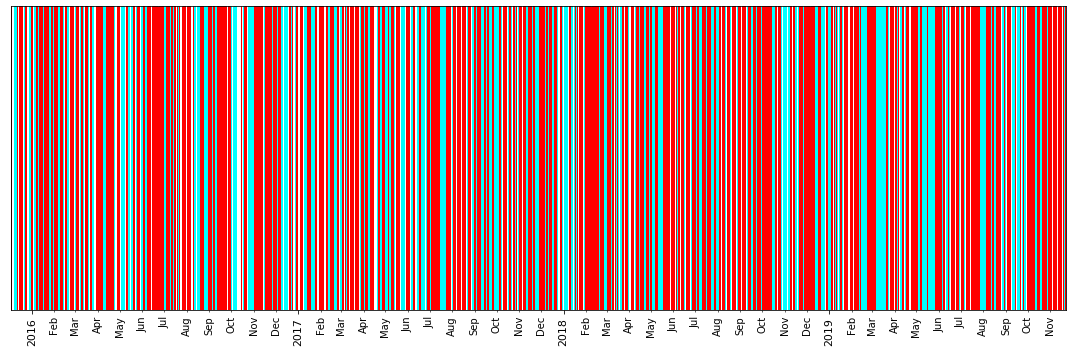

In [263]:
predictions_barplot_multi()

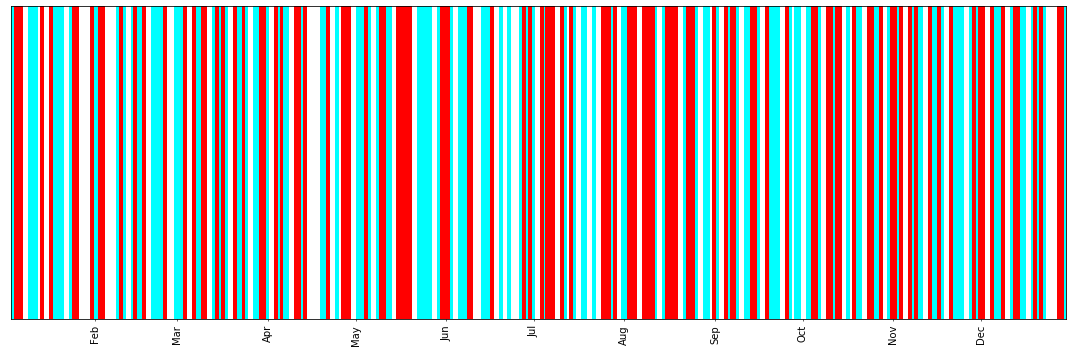

In [264]:
predictions_barplot_multi('2017')

Our predictions are now much more filled out than previously! Clearly we have identified a much more appropriate test split method.

There are still white spaces in our data. This is due to daily data preceding flat price days being removed, and for there being no stock data on weekends or holidays.

If you zoom in on a particular month you can see that the missing data in weekends is indeed consistent. Let's ignore that fact and focus on the red and cyan data.

Can you see any consistencies in the model's predictions? I can't. Let's plot 3 full years of predictions for 2016-2018 stacked on top of each other and see if that makes finding any consistencies or seasonality easier.

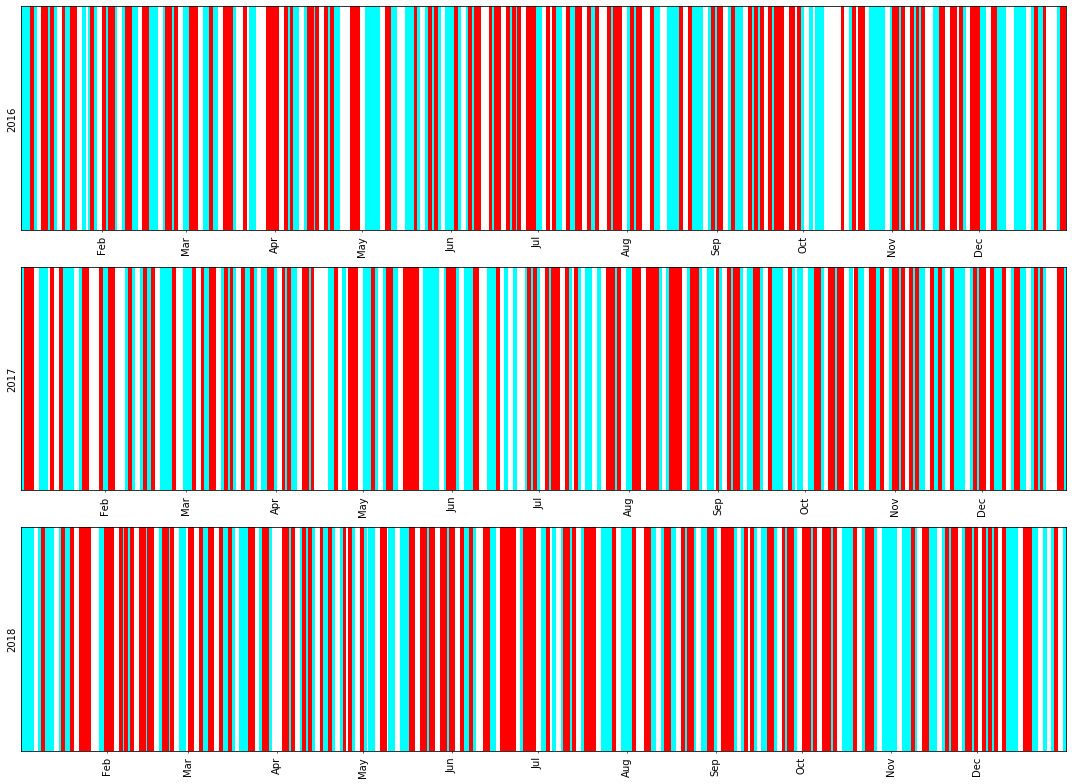

In [265]:
import matplotlib.dates

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 11))

yearFmt = matplotlib.dates.DateFormatter("%Y")
monthFmt = matplotlib.dates.DateFormatter("%b")

# List used to collate number of correct and incorrect predictions per year
per_yr_predictions = []

for yr, axn in [('2016', ax1), ('2017', ax2), ('2018', ax3)]:
    
    s = predictions_compare_multi['correct_predictions'][yr:yr]
    plt.axes(axn)

    # plot cyan for event == 1
    s1 = s[s == 1]
    per_yr_predictions.append( (yr, 'Correct', len(s1)) )
    inxval = matplotlib.dates.date2num(s1.index.to_pydatetime())
    times= zip(inxval, np.ones(len(s1)))
    times = list(times)
    plt.broken_barh(times, (-1,1), color="cyan")

    # plot red for event==0
    s2 = s[s == 0]
    per_yr_predictions.append( (yr, 'Incorrect', len(s2)) )
    inxval = matplotlib.dates.date2num(s2.index.to_pydatetime())
    times= zip(inxval, np.ones(len(s2)))
    times = list(times)
    plt.broken_barh(times, (-1,1), color="red")

    axn.margins(0)
    axn.set_yticks([])
    axn.set_ylabel(yr)
    axn.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    axn.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
    axn.xaxis.set_major_formatter(yearFmt)
    axn.xaxis.set_minor_formatter(monthFmt)

    plt.xticks(rotation=90, fontsize=11)
    plt.setp(axn.xaxis.get_minorticklabels(), rotation=90, fontsize=10)
    plt.tight_layout()

plt.show()

Even stacked on top of each other, it is still difficult to find notable consistencies in the data.

Perhaps if we zoomed in further to monthly or weekly timeframes it would be more obvious, or perhaps there isn't any consistency or seasonality in the data at all! Further analysis is required.

## Yearly predictions comparison

In the above I collated a list of the count of correct and incorrect predictions per year. Let's look at this below.

In [266]:
per_yr_predictions_df = pd.DataFrame(per_yr_predictions, columns = ['Year', 'Prediction', 'Count']).set_index('Year')
per_yr_predictions_df

,Prediction,Count
Year,,
2016,Correct,122
2016,Incorrect,113
2017,Correct,127
2017,Incorrect,110
2018,Correct,122
2018,Incorrect,125


There are a few things to note about this data:

- 2016 and 2017 appear fairly consistent, while 2018 has far greater incorrect predictions. 
- The count of total predictions in 2018 is 247, which is greater than that of 235 in 2016 and 237 in 2017. The reason for this is most likely due to there being less flat day price moves occuring due to the price of A2M.AX getting highter, and thus there being less data points removed from the data in 2018.

It is possible that the predictions in 2018 are less accurate compared to prior years because older training data from as earlier as mid 2015 is still being used to train the model to predict price movements in 2018. The stock characteristics went through massive changes in this 3 year period, and the statistics between these two periods are widely different. 

A2M.AX in 2018 (and beyond) appears to be in a different state to where it was a few years prior, as can be seen mostly by the increased volatility. Due to this, perhaps we could retrain and test our model using a maximum size per training split. In effect, this would mean our models per split are being trained only on the most recent x data points, rather than continuing to be trained on more historical and perhaps less relevant data.

We can easily set a maximum training size per split by setting parameter `max_train_size` in  `TimeSeriesSplit(n_splits=warm, max_train_size=None)` .

## Conclusion

It goes without saying that it is not a simple task to predict future stock price movements, or even more so, the extent of these movements! Nevertheless, it has still been a fun process to see if any of our stock related volume and price data could help with this prediction. 

For this particular analysis, it seems clear that we have not founded a crystal ball for stock price movements. The accuracy scores for our models, albeit above 50 percent for the overall analysis, perform poorly on more recent data (122/247 = 0.494 accuracy score in 2018). This can be attributed to the unpredictable nature of the stock market, as can be seen in the year 2018 for A2M.AX, which was significantly more volatile than prior years.

Of course we could venture far deeper in to this analysis. We could try different machine learning algorithms to the `Decision Tree Classifer`, such as `Random Forest` (constructs a multitude of decision trees at training time and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees - Random decision forests correct for decision trees' habit of overfitting to their training set), `Support Vector Machines (SVMs)` or `Logistic Regression`. Alternatively, we could implement a `walk forward train-test model` with a maximum training size so as to make our features more relavant to the current training data at the sacrifice of potentially less relavant historical data. 

The potential for further analysis is really endless - the features themselves can be explored further by looking at mean, mode, median, standardard deviation and autocorrelation (correlation of data on lagged versions of itself) among other statistical measures. The deeper the analysis, the higher the risk of data mining occuring - e.g. mining data until you find something that confirms your viewpoint, without your findings having any statistical significance.

Due to the endless nature of such an analysis, I have decided to cut it here. I will certainly be investigating further in to similar analysis in the future, along with learning and practicing techniques to improve my analysis on time series, particularly using market datasets.

# Bonus bits - not part of initial project (incomplete..)

## Let's see if using autocorrelation we can get more fruitful results.

The autocorrelation formula is below. We can check this to verify we're getting what we want. It represents the `autocorrelation function at lag k`.

![image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR07iiMJJYdDztMGGrem2CSdBJ4V3g4MsBM-TEoaxBiZZJ6iwjy)

To calculate autocorrelation lets import the autocorrelation function `acf` from `statsmodels`:

**Note: We do not use Panda's `.autocorr()` funtion as it returns the Pearson Correlation Coefficient rather than the Autocorrelation.**

`acf` uses the overall series sample mean and sample variance to determine the correlation coefficient (formula above). 

Pearsons Correlation Coefficient on the other hand uses sample mean and sample variance of each subseries to determine the correlation coefficient (formula below).

![image](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRJTFuwQcRWmiVf_N16MgP_-HY64lP5P0B0natLUk1L4CbuCy3f)

For further info on differences, see : https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf

In [267]:
from statsmodels.tsa.stattools import acf
?acf

As per the documentation - `acf(array, nlags=40)` returns the autocorrelation function for 1d arrays. 

The `nlags` optional argument specifies the number of lags to return autocorrelation for. The result is returned in an array. For given nlags = k, the array of acf returned is for k and smaller lags, iterating by 1 to 0.

Panda's dataframe method `.rolling(window)` provides rolling window calculations. We will use this for calculating autocorrelation for each data point.

In [270]:
rng_data = data['range_over_open']

print(rng_data[-20:])

auto_test = rng_data.rolling(5).apply(lambda x: x.autocorr(lag=1).round(4), raw=False)
auto_test[-20:]

date
2019-10-25    0.021115
2019-10-28    0.011667
2019-10-29    0.013289
2019-10-30    0.012448
2019-10-31    0.009136
2019-11-01    0.009159
2019-11-04    0.010735
2019-11-05    0.029630
2019-11-06    0.043793
2019-11-07    0.034483
2019-11-08    0.031489
2019-11-11    0.019130
2019-11-12    0.022944
2019-11-13    0.029737
2019-11-14    0.063090
2019-11-15    0.020248
2019-11-18    0.023333
2019-11-19    0.071530
2019-11-20    0.033210
2019-11-21    0.023415
Name: range_over_open, dtype: float64


date
2019-10-25    0.1662
2019-10-28    0.1156
2019-10-29    0.4998
2019-10-30    0.7795
2019-10-31   -0.0142
2019-11-01    0.4745
2019-11-04    0.4432
2019-11-05    0.1169
2019-11-06    0.8660
2019-11-07    0.6618
2019-11-08    0.2937
2019-11-11    0.0212
2019-11-12    0.7099
2019-11-13    0.1536
2019-11-14    0.3326
2019-11-15   -0.2623
2019-11-18   -0.2819
2019-11-19   -0.4980
2019-11-20   -0.4325
2019-11-21   -0.1987
Name: range_over_open, dtype: float64

In [272]:
rng_data = data['range_over_open']

print(rng_data[-20:])

#auto_test = rng_data.rolling(5).apply(lambda x: acf(x, nlags=1)[1].round(4), raw=False)
auto_test = rng_data.rolling(4).apply(lambda x: (acf(x, nlags=1)[1]+acf(x, nlags=2)[2]).round(4), raw=False)
auto_test[-20:]

date
2019-10-25    0.021115
2019-10-28    0.011667
2019-10-29    0.013289
2019-10-30    0.012448
2019-10-31    0.009136
2019-11-01    0.009159
2019-11-04    0.010735
2019-11-05    0.029630
2019-11-06    0.043793
2019-11-07    0.034483
2019-11-08    0.031489
2019-11-11    0.019130
2019-11-12    0.022944
2019-11-13    0.029737
2019-11-14    0.063090
2019-11-15    0.020248
2019-11-18    0.023333
2019-11-19    0.071530
2019-11-20    0.033210
2019-11-21    0.023415
Name: range_over_open, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


date
2019-10-25   -0.6382
2019-10-28   -0.4062
2019-10-29   -0.2049
2019-10-30   -0.2535
2019-10-31   -0.4918
2019-11-01   -0.2030
2019-11-04   -0.6021
2019-11-05   -0.2245
2019-11-06   -0.1455
2019-11-07   -0.3429
2019-11-08   -0.6478
2019-11-11   -0.0128
2019-11-12   -0.3033
2019-11-13   -0.7205
2019-11-14   -0.1451
2019-11-15   -0.6294
2019-11-18   -0.5403
2019-11-19   -0.7368
2019-11-20   -0.5389
2019-11-21   -0.6335
Name: range_over_open, dtype: float64

##  Let's simplify things and see if range over open price can help determine the next day's price movement.

In [274]:
data.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'range_over_open',
       'range_change', 'range_move', 'price_change', 'tomo_price_move',
       'volume', 'qty_change', 'qty_move', '5d_avg_range',
       'change_in_5d_avg_range', '5d_avg_range_move', '5d_avg_px',
       'change_in_5d_avg_px', '5d_avg_px_move', '5d_avg_qty',
       'change_in_5d_avg_qty', '5d_avg_qty_move', '10d_avg_px',
       'change_in_10d_avg_px', '10d_avg_px_move'],
      dtype='object')

Let's first make tomorrow's price movement classifier either up or down, and remove all data samples where price movement is flat for the day.

In addition let's convert up to value 1, and down to value 0, thus creating a binary target.

In [275]:
data_updown = data.copy()
data_updown.shape

(1169, 25)

In [276]:
updown_mask = data_updown['tomo_price_move'] != 'Flat'
data_updown = data_updown[updown_mask]
data_updown['tomo_price_move'].replace({'Up' : 1, 'Down' : 0}, inplace=True)

In [277]:
data_updown.head()

,open,high,low,close,adj_close,range_over_open,range_change,range_move,price_change,tomo_price_move,...,5d_avg_range_move,5d_avg_px,change_in_5d_avg_px,5d_avg_px_move,5d_avg_qty,change_in_5d_avg_qty,5d_avg_qty_move,10d_avg_px,change_in_10d_avg_px,10d_avg_px_move
date,,,,,,,,,,,,,,,,,,,,,
2015-04-16,0.545,0.545,0.525,0.530,0.530,0.036697,0.018179,Up,-0.01,1,...,Up,0.537,-0.001,Down,526133.4,-22846.6,Down,0.5425,-0.0035,Down
2015-04-17,0.525,0.540,0.520,0.540,0.540,0.038095,0.001398,Up,0.01,0,...,Up,0.538,0.001,Up,600670.6,74537.2,Up,0.5400,-0.0025,Down
2015-04-22,0.520,0.530,0.520,0.520,0.520,0.019231,0.000183,Up,0.00,0,...,Up,0.526,-0.004,Down,511622.2,-106671.8,Down,0.5320,-0.0020,Down
2015-04-23,0.520,0.520,0.510,0.510,0.510,0.019231,0.000000,Flat,-0.01,0,...,Down,0.522,-0.004,Down,678138.4,166516.2,Up,0.5295,-0.0025,Down
2015-04-27,0.505,0.510,0.500,0.505,0.505,0.019802,-0.019414,Down,0.00,0,...,Down,0.512,-0.003,Down,751161.0,-30650.4,Down,0.5230,-0.0035,Down


Let's try taking autocorrelation of range_over_price and see if we can get anything fruitful.